# Resolved MZR (D16) by SFR Surface Density Bins

Analysis of how rMZR behaves when divided into Σ_SFR bins (-4 to 1, with 0.5 bin width), focusing only on D16 calibration.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
from matplotlib.colors import LogNorm
from pathlib import Path
from astropy.io import fits
import scipy.stats as stats
from scipy.optimize import curve_fit
import warnings

# Set up matplotlib for high-quality plots
plt.rcParams['figure.dpi'] = 150
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

# 0 · discover galaxies & colour palette
bins      = sorted(Path('.').glob('*_SPATIAL_BINNING_maps_extended.fits'))
galaxies  = [f.name.split('_')[0] for f in bins]          # 14 expected
ngal      = len(galaxies)
print(f"Found {ngal} galaxies: {galaxies}")

# Check if we have the expected data files
gas_files = [f"{gal}_gas_BIN_maps_extended.fits" for gal in galaxies]
available_files = [Path(f).exists() for f in gas_files]
print(f"Available gas files: {sum(available_files)}/{len(gas_files)}")

if not any(available_files):
    print("ERROR: No extended gas files found. Data may need to be processed first.")
    print("Expected files like: *_gas_BIN_maps_extended.fits")
else:
    print(f"Available galaxies: {[gal for i, gal in enumerate(galaxies) if available_files[i]]}")

Found 14 galaxies: ['IC3392', 'NGC4064', 'NGC4192', 'NGC4293', 'NGC4298', 'NGC4330', 'NGC4383', 'NGC4396', 'NGC4419', 'NGC4457', 'NGC4501', 'NGC4522', 'NGC4694', 'NGC4698']
Available gas files: 14/14
Available galaxies: ['IC3392', 'NGC4064', 'NGC4192', 'NGC4293', 'NGC4298', 'NGC4330', 'NGC4383', 'NGC4396', 'NGC4419', 'NGC4457', 'NGC4501', 'NGC4522', 'NGC4694', 'NGC4698']


In [2]:
# Load maps helper (Σ*, Σ_SFR, [O/H] D16)
def load_maps_d16(gal):
    """Load stellar mass surface density, SFR surface density, and D16 metallicity maps"""
    try:
        with fits.open(f'{gal}_SPATIAL_BINNING_maps_extended.fits') as h:
            sigM = h['LOGMASS_SURFACE_DENSITY'].data
        with fits.open(f'{gal}_gas_BIN_maps_extended.fits') as h:
            sigSFR_SF = h['LOGSFR_SURFACE_DENSITY_SF'].data
            oh_d16 = h['O_H_D16_SF'].data
        return sigM, sigSFR_SF, oh_d16
    except Exception as e:
        print(f"Error loading {gal}: {e}")
        return None, None, None

def calculate_median_statistics(x, y, x_range=(6, 11), bin_width=0.2):
    """Calculate median and std in binned intervals for x vs y"""
    x_bins = np.arange(x_range[0], x_range[1] + bin_width, bin_width)
    x_centers = (x_bins[:-1] + x_bins[1:]) / 2
    
    medians = []
    stds = []
    x_valid = []
    counts = []
    
    for i in range(len(x_bins) - 1):
        mask = (x >= x_bins[i]) & (x < x_bins[i + 1])
        if np.sum(mask) >= 10:  # Need at least 10 points for statistics
            y_bin = y[mask]
            medians.append(np.median(y_bin))
            stds.append(np.std(y_bin))
            x_valid.append(x_centers[i])
            counts.append(len(y_bin))
    
    return np.array(x_valid), np.array(medians), np.array(stds), np.array(counts)

# Test loading a single galaxy to verify data availability
if galaxies:
    test_gal = galaxies[0]
    sigM_test, sigSFR_test, oh_d16_test = load_maps_d16(test_gal)
    if sigM_test is not None:
        print(f"Successfully loaded {test_gal}")
        print(f"  - sigM shape: {sigM_test.shape}, valid points: {np.sum(np.isfinite(sigM_test))}")
        print(f"  - sigSFR shape: {sigSFR_test.shape}, valid points: {np.sum(np.isfinite(sigSFR_test))}")
        print(f"  - oh_d16 shape: {oh_d16_test.shape}, valid points: {np.sum(np.isfinite(oh_d16_test))}")
        
        # Check data ranges
        if np.any(np.isfinite(sigSFR_test)):
            sfr_range = (np.nanmin(sigSFR_test), np.nanmax(sigSFR_test))
            print(f"  - SFR surface density range: {sfr_range[0]:.2f} to {sfr_range[1]:.2f}")
        if np.any(np.isfinite(oh_d16_test)):
            oh_range = (np.nanmin(oh_d16_test), np.nanmax(oh_d16_test))
            print(f"  - [O/H] D16 range: {oh_range[0]:.2f} to {oh_range[1]:.2f}")
    else:
        print(f"Failed to load {test_gal}")

Successfully loaded IC3392
  - sigM shape: (438, 437), valid points: 73168
  - sigSFR shape: (438, 437), valid points: 19853
  - oh_d16 shape: (438, 437), valid points: 19776
  - SFR surface density range: -3.72 to -0.52
  - [O/H] D16 range: 8.63 to 9.12


In [3]:
# Define SFR surface density bins: -4 to 1 with 0.5 bin width
sfr_bin_edges = np.arange(-4.0, 1.5, 0.5)  # [-4, -3.5, -3, -2.5, -2, -1.5, -1, -0.5, 0, 0.5, 1]
sfr_bin_centers = (sfr_bin_edges[:-1] + sfr_bin_edges[1:]) / 2
n_sfr_bins = len(sfr_bin_centers)

print(f"SFR bins ({n_sfr_bins} total):")
for i, (left, right, center) in enumerate(zip(sfr_bin_edges[:-1], sfr_bin_edges[1:], sfr_bin_centers)):
    print(f"  Bin {i+1}: [{left:.1f}, {right:.1f}) -> center = {center:.1f}")

# Collect all data from all galaxies
all_sigM = []
all_sigSFR = []
all_oh_d16 = []
galaxy_data = {}  # Store per-galaxy data for later analysis

for gal in galaxies:
    sigM, sigSFR, oh_d16 = load_maps_d16(gal)
    
    if sigM is not None:
        # Create combined mask for valid data points
        good_mask = (np.isfinite(sigM) & 
                    np.isfinite(sigSFR) & 
                    np.isfinite(oh_d16))
        
        if np.any(good_mask):
            sigM_valid = sigM[good_mask]
            sigSFR_valid = sigSFR[good_mask]
            oh_d16_valid = oh_d16[good_mask]
            
            all_sigM.extend(sigM_valid)
            all_sigSFR.extend(sigSFR_valid)
            all_oh_d16.extend(oh_d16_valid)
            
            galaxy_data[gal] = {
                'sigM': sigM_valid,
                'sigSFR': sigSFR_valid,
                'oh_d16': oh_d16_valid,
                'n_points': len(sigM_valid)
            }
            
            print(f"{gal}: {len(sigM_valid)} valid spaxels")
        else:
            print(f"{gal}: No valid data points")
    else:
        print(f"{gal}: Could not load data")

# Convert to numpy arrays
all_sigM = np.array(all_sigM)
all_sigSFR = np.array(all_sigSFR)
all_oh_d16 = np.array(all_oh_d16)

print(f"\nTotal combined data: {len(all_sigM)} spaxels")
print(f"SFR surface density range: {np.min(all_sigSFR):.2f} to {np.max(all_sigSFR):.2f}")
print(f"Stellar mass surface density range: {np.min(all_sigM):.2f} to {np.max(all_sigM):.2f}")
print(f"[O/H] D16 range: {np.min(all_oh_d16):.3f} to {np.max(all_oh_d16):.3f}")

SFR bins (10 total):
  Bin 1: [-4.0, -3.5) -> center = -3.8
  Bin 2: [-3.5, -3.0) -> center = -3.2
  Bin 3: [-3.0, -2.5) -> center = -2.8
  Bin 4: [-2.5, -2.0) -> center = -2.2
  Bin 5: [-2.0, -1.5) -> center = -1.8
  Bin 6: [-1.5, -1.0) -> center = -1.2
  Bin 7: [-1.0, -0.5) -> center = -0.8
  Bin 8: [-0.5, 0.0) -> center = -0.2
  Bin 9: [0.0, 0.5) -> center = 0.2
  Bin 10: [0.5, 1.0) -> center = 0.8
IC3392: 19776 valid spaxels
NGC4064: 15512 valid spaxels
NGC4192: 275015 valid spaxels
NGC4293: 9037 valid spaxels
NGC4298: 181696 valid spaxels
NGC4330: 43891 valid spaxels
NGC4383: 75127 valid spaxels
NGC4396: 81748 valid spaxels
NGC4419: 22470 valid spaxels
NGC4457: 24440 valid spaxels
NGC4501: 419190 valid spaxels
NGC4522: 40671 valid spaxels
NGC4694: 3851 valid spaxels
NGC4698: 34508 valid spaxels

Total combined data: 1246932 spaxels
SFR surface density range: -3.89 to 1.56
Stellar mass surface density range: 6.55 to 11.17
[O/H] D16 range: 7.715 to 9.230


In [4]:
# Bin the data by SFR surface density and analyze rMZR in each bin
binned_data = {}
bin_statistics = []

for i, (left_edge, right_edge, center) in enumerate(zip(sfr_bin_edges[:-1], sfr_bin_edges[1:], sfr_bin_centers)):
    # Select data points in this SFR bin
    sfr_mask = (all_sigSFR >= left_edge) & (all_sigSFR < right_edge)
    
    if np.sum(sfr_mask) > 0:
        bin_sigM = all_sigM[sfr_mask]
        bin_oh_d16 = all_oh_d16[sfr_mask]
        
        # Calculate median statistics for rMZR in this SFR bin
        if len(bin_sigM) >= 10:  # Minimum points for meaningful statistics
            x_median, y_median, y_std, counts = calculate_median_statistics(
                bin_sigM, bin_oh_d16, x_range=(6, 11), bin_width=0.2
            )
            
            binned_data[i] = {
                'center': center,
                'range': (left_edge, right_edge),
                'sigM': bin_sigM,
                'oh_d16': bin_oh_d16,
                'n_points': len(bin_sigM),
                'x_median': x_median,
                'y_median': y_median,
                'y_std': y_std,
                'counts': counts
            }
            
            # Calculate simple statistics
            median_oh = np.median(bin_oh_d16)
            std_oh = np.std(bin_oh_d16)
            
            bin_statistics.append({
                'bin_idx': i,
                'sfr_center': center,
                'sfr_range': f"[{left_edge:.1f}, {right_edge:.1f})",
                'n_points': len(bin_sigM),
                'median_oh': median_oh,
                'std_oh': std_oh,
                'median_sigM': np.median(bin_sigM),
                'std_sigM': np.std(bin_sigM)
            })
            
            print(f"SFR bin {center:.1f}: {len(bin_sigM)} points, [O/H] = {median_oh:.3f} ± {std_oh:.3f}")
        else:
            print(f"SFR bin {center:.1f}: {np.sum(sfr_mask)} points (too few for analysis)")
    else:
        print(f"SFR bin {center:.1f}: no data points")

print(f"\nUsable SFR bins: {len(binned_data)}/{n_sfr_bins}")

SFR bin -3.8: 5875 points, [O/H] = 8.900 ± 0.258
SFR bin -3.2: 51441 points, [O/H] = 8.738 ± 0.290
SFR bin -2.8: 241638 points, [O/H] = 8.675 ± 0.239
SFR bin -2.2: 401959 points, [O/H] = 8.702 ± 0.208
SFR bin -1.8: 343829 points, [O/H] = 8.752 ± 0.196
SFR bin -1.2: 156820 points, [O/H] = 8.797 ± 0.175
SFR bin -0.8: 36789 points, [O/H] = 8.830 ± 0.192
SFR bin -0.2: 7113 points, [O/H] = 8.750 ± 0.234
SFR bin 0.2: 1305 points, [O/H] = 8.718 ± 0.201
SFR bin 0.8: 137 points, [O/H] = 8.586 ± 0.129

Usable SFR bins: 10/10


/var/folders/rm/clp89v210v32vh5vjt2kx7b80000gr/T/ipykernel_25742/483569996.py:114: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


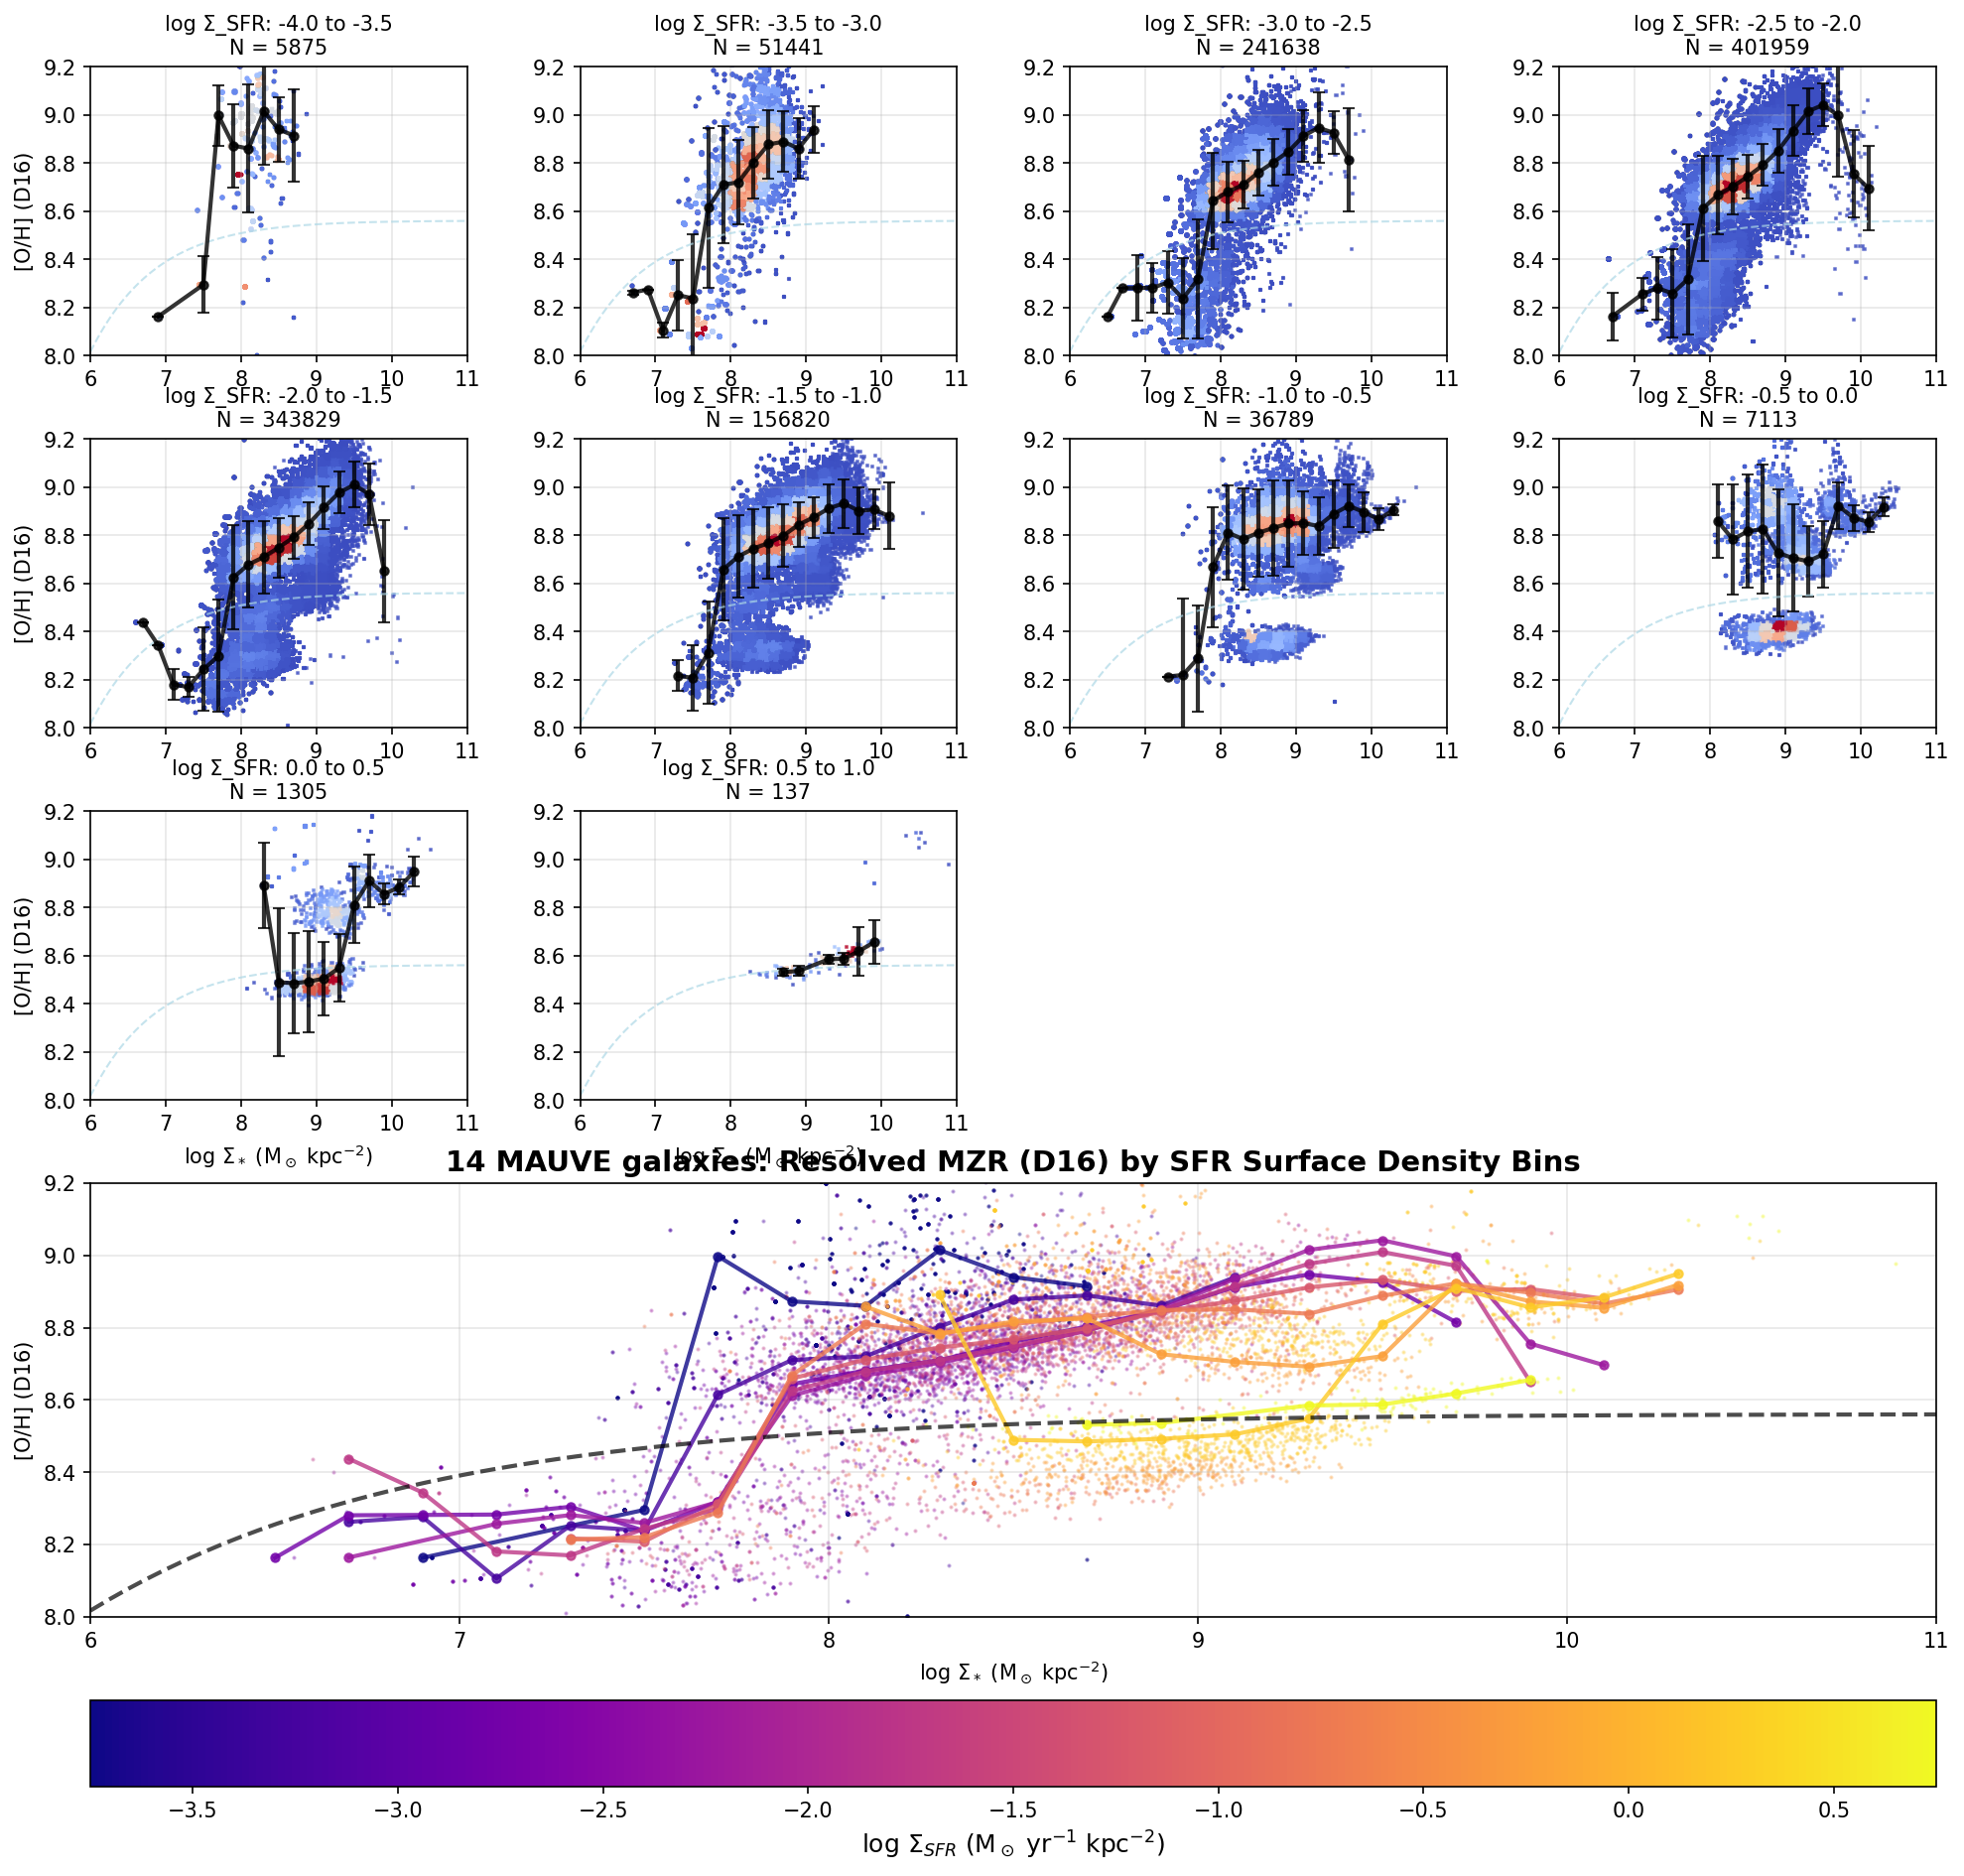

In [5]:
# Create the main plot: rMZR in different SFR surface density bins
n_bins = len(binned_data)
if n_bins == 0:
    print("No usable bins for plotting!")
else:
    # Determine subplot layout
    n_cols = min(4, n_bins)  # Maximum 4 columns
    n_rows = int(np.ceil(n_bins / n_cols))
    if n_bins <= 6:
        n_cols = min(3, n_bins)
        n_rows = int(np.ceil(n_bins / n_cols))
    
    # Create figure with subplot for combined plot
    fig = plt.figure(figsize=(max(16, n_cols * 4), max(12, n_rows * 3 + 6)))
    gs = GridSpec(n_rows + 2, n_cols, figure=fig, 
                  height_ratios=[1] * n_rows + [1.5, 0.3], 
                  hspace=0.3, wspace=0.3)
    
    # Color map for SFR surface density
    cmap = plt.cm.plasma
    sfr_values = [binned_data[i]['center'] for i in sorted(binned_data.keys())]
    norm = plt.Normalize(vmin=min(sfr_values), vmax=max(sfr_values))
    
    # Plot individual SFR bins
    for plot_idx, bin_idx in enumerate(sorted(binned_data.keys())):
        data = binned_data[bin_idx]
        
        row = plot_idx // n_cols
        col = plot_idx % n_cols
        ax = fig.add_subplot(gs[row, col])
        
        # Scatter plot with density coloring
        H, xedges, yedges = np.histogram2d(data['sigM'], data['oh_d16'], bins=30, 
                                          range=[[6, 11], [8.0, 9.2]])
        x_idx = np.clip(np.digitize(data['sigM'], xedges) - 1, 0, H.shape[0] - 1)
        y_idx = np.clip(np.digitize(data['oh_d16'], yedges) - 1, 0, H.shape[1] - 1)
        density = H[x_idx, y_idx]
        
        scatter = ax.scatter(data['sigM'], data['oh_d16'], c=density, s=1, alpha=0.6, 
                           cmap='coolwarm', marker=',')
        
        # Plot median trend
        if len(data['x_median']) > 0:
            ax.errorbar(data['x_median'], data['y_median'], yerr=data['y_std'],
                       fmt='ko-', linewidth=2, markersize=4, capsize=3, alpha=0.8)
        
        # Add literature fits for reference
        x_lit = np.linspace(6, 11, 100)
        # Koller+24: 12 + log(O/H) = 8.561 + 0.0001 * (log Σ* - 12.7) * exp(-(log Σ* - 12.7))
        y_koller24 = 8.561 + 0.0001 * (x_lit - 12.7) * np.exp(-(x_lit - 12.7))
        ax.plot(x_lit, y_koller24, '--', color='lightblue', linewidth=1, alpha=0.7)
        
        # Formatting
        ax.set_xlim(6, 11)
        ax.set_ylim(8.0, 9.2)
        ax.grid(True, alpha=0.3)
        
        # Title with SFR bin info
        sfr_range = data['range']
        ax.set_title(f"log Σ_SFR: {sfr_range[0]:.1f} to {sfr_range[1]:.1f}\nN = {data['n_points']}", 
                    fontsize=10)
        
        # Labels only on edge subplots
        if row == n_rows - 1:
            ax.set_xlabel(r'log Σ$_*$ (M$_\odot$ kpc$^{-2}$)')
        if col == 0:
            ax.set_ylabel(r'[O/H] (D16)')
    
    # Combined plot showing all bins together
    ax_combined = fig.add_subplot(gs[n_rows, :])
    
    # Plot each SFR bin with different colors
    for bin_idx in sorted(binned_data.keys()):
        data = binned_data[bin_idx]
        color = cmap(norm(data['center']))
        
        # Sample data for visibility (plot every nth point if too dense)
        n_points = len(data['sigM'])
        if n_points > 1000:
            indices = np.random.choice(n_points, 1000, replace=False)
            sigM_plot = data['sigM'][indices]
            oh_plot = data['oh_d16'][indices]
        else:
            sigM_plot = data['sigM']
            oh_plot = data['oh_d16']
        
        ax_combined.scatter(sigM_plot, oh_plot, s=1, alpha=0.3, color=color, 
                          label=f"{data['center']:.1f}")
        
        # Plot median trend for this bin
        if len(data['x_median']) > 0:
            ax_combined.plot(data['x_median'], data['y_median'], 'o-', 
                           color=color, linewidth=2, markersize=4, alpha=0.8)
    
    # Add literature reference
    ax_combined.plot(x_lit, y_koller24, '--', color='black', linewidth=2, 
                    alpha=0.7, label='Koller+24')
    
    ax_combined.set_xlim(6, 11)
    ax_combined.set_ylim(8.0, 9.2)
    ax_combined.grid(True, alpha=0.3)
    ax_combined.set_xlabel(r'log Σ$_*$ (M$_\odot$ kpc$^{-2}$)')
    ax_combined.set_ylabel(r'[O/H] (D16)')
    ax_combined.set_title('14 MAUVE galaxies: Resolved MZR (D16) by SFR Surface Density Bins', 
                         fontsize=14, fontweight='bold')
    
    # Create colorbar for SFR surface density
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cbar_ax = fig.add_subplot(gs[n_rows + 1, :])
    cbar = fig.colorbar(sm, cax=cbar_ax, orientation='horizontal')
    cbar.set_label(r'log Σ$_{SFR}$ (M$_\odot$ yr$^{-1}$ kpc$^{-2}$)', fontsize=12)
    
    plt.tight_layout()
    plt.show()

In [6]:
# Print detailed statistics table
print("\n" + "="*80)
print("MEDIAN STATISTICS - D16 MZR by SFR bins")
print("="*80)
print(f"{'SFR BIN':<12} {'N_spax':<8} {'Median[O/H]':<12} {'Std[O/H]':<12} {'Range':<15}")
print(f"{'(center)':<12} {'count':<8} {'D16':<12} {'D16':<12} {'[left,right)':<15}")
print("-"*80)

for stat in bin_statistics:
    print(f"{stat['sfr_center']:<12.1f} {stat['n_points']:<8} {stat['median_oh']:<12.3f} "
          f"{stat['std_oh']:<12.3f} {stat['sfr_range']:<15}")

print("\n" + "="*80)
print("COMBINED ANALYSIS:")
print(f"Total D16 spaxels: {len(all_sigM):,}")
print(f"Total usable SFR bins: {len(binned_data)}/{n_sfr_bins}")
print(f"SFR surface density range: {np.min(all_sigSFR):.2f} to {np.max(all_sigSFR):.2f}")
print(f"Overall [O/H] range: {np.min(all_oh_d16):.3f} to {np.max(all_oh_d16):.3f}")
print(f"Overall [O/H] median: {np.median(all_oh_d16):.3f} ± {np.std(all_oh_d16):.3f}")

# Check for trend in metallicity vs SFR
if len(bin_statistics) > 2:
    sfr_centers = [stat['sfr_center'] for stat in bin_statistics]
    median_ohs = [stat['median_oh'] for stat in bin_statistics]
    
    # Calculate correlation
    correlation, p_value = stats.pearsonr(sfr_centers, median_ohs)
    print(f"\nCorrelation between SFR bin center and median [O/H]: {correlation:.3f} (p={p_value:.3f})")
    
    # Linear fit
    slope, intercept = np.polyfit(sfr_centers, median_ohs, 1)
    print(f"Linear trend: [O/H] = {slope:.4f} * log(Σ_SFR) + {intercept:.3f}")
    
    if abs(correlation) > 0.5:
        if correlation > 0:
            print("-> POSITIVE correlation: Higher SFR surface density -> Higher metallicity")
        else:
            print("-> NEGATIVE correlation: Higher SFR surface density -> Lower metallicity")
    else:
        print("-> WEAK correlation: No clear trend between SFR surface density and metallicity")

print("="*80)


MEDIAN STATISTICS - D16 MZR by SFR bins
SFR BIN      N_spax   Median[O/H]  Std[O/H]     Range          
(center)     count    D16          D16          [left,right)   
--------------------------------------------------------------------------------
-3.8         5875     8.900        0.258        [-4.0, -3.5)   
-3.2         51441    8.738        0.290        [-3.5, -3.0)   
-2.8         241638   8.675        0.239        [-3.0, -2.5)   
-2.2         401959   8.702        0.208        [-2.5, -2.0)   
-1.8         343829   8.752        0.196        [-2.0, -1.5)   
-1.2         156820   8.797        0.175        [-1.5, -1.0)   
-0.8         36789    8.830        0.192        [-1.0, -0.5)   
-0.2         7113     8.750        0.234        [-0.5, 0.0)    
0.2          1305     8.718        0.201        [0.0, 0.5)     
0.8          137      8.586        0.129        [0.5, 1.0)     

COMBINED ANALYSIS:
Total D16 spaxels: 1,246,932
Total usable SFR bins: 10/10
SFR surface density range: -3.89